# PC-2 versus Indices

## Imports and Functions

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, MinMaxScaler
import scipy as sp
from ipywidgets import interact
import plotly.graph_objects as go
import datetime


In [61]:
def drop_norm(vec):
    valid_columns = ~np.isnan(vec).any(axis=0)  # Identify valid columns (non-NaN)
    vec = vec[:, valid_columns]  #DROP

    scaler = MinMaxScaler()
    scaler.fit(vec)
    return scaler.transform(vec), valid_columns

def is_month(month, n):
    return month == n
    
def flatten_vector(ds, length):
    sst_flatten, sst_valid = drop_norm(ds.sst.to_numpy().reshape(length, -1))
    sp_flatten, sp_valid = drop_norm(ds.sp.to_numpy().reshape(length, -1))
    ttr_flatten, ttr_valid = drop_norm(ds.ttr.to_numpy().reshape(length, -1))
    u10_flatten, u10_valid = drop_norm(ds.u10.to_numpy().reshape(length, -1))
    v10_flatten, v10_valid = drop_norm(ds.v10.to_numpy().reshape(length, -1))

    flatten=  np.concatenate((sst_flatten, sp_flatten, ttr_flatten, u10_flatten, v10_flatten), axis=1)
    flatten = detrend_data(flatten)
    flatten = flatten -np.mean(flatten, axis=0)

    return flatten, np.concatenate((sst_valid, sp_valid, ttr_valid, u10_valid, v10_valid))


def detrend_data(matrix):
    n_timesteps, n_variables = matrix.shape
    time = np.arange(n_timesteps)
    detrended_matrix = np.zeros_like(matrix)
    
    # Detrend each column (each time series) individually
    for i in range(n_variables):
        y = matrix[:, i]
        
        # Perform a linear regression to get the slope and intercept
        slope, intercept, _, _, _ = sp.stats.linregress(time, y)
        trend = slope * time + intercept
        
        # Subtract the trend from the original data
        detrended_matrix[:, i] = y - trend
    
    return detrended_matrix

def get_first_pc(dataset, reference_period, biseason, nmodes):
    bimonthly = dataset.rolling(time=2, center=True).mean() #first month is DJ
    target_bimonth = bimonthly.sel(time=is_month(bimonthly['time.month'], biseason))
    target_bimonth = target_bimonth.sel(time=slice(f"{reference_period[0]}-01", f"{reference_period[1]}-12"))

    flatten_bimonth, valid_columns = flatten_vector(target_bimonth, target_bimonth.sizes["time"])

    cov_matrix = np.matmul(flatten_bimonth, flatten_bimonth.T)/(flatten_bimonth.shape[0]-1)
    N = cov_matrix.shape[0]
    D, V= sp.linalg.eigh(cov_matrix, subset_by_index=[N-nmodes,N-1])

    # Reverse
    D = D[::-1]
    V = V[:, ::-1]

    pcs = []
    modes = []

    for i in range(nmodes):
        # Project kth eigenvector onto the original space
        V_k = np.matmul(flatten_bimonth.T, V[:, i])
        
        # Normalize the mode
        sq = np.sqrt(D[i])
        V_k = V_k / sq
        
        # Compute the principal component time series
        pc_k = V_k.T @ flatten_bimonth.T / (np.dot(V_k.T, V_k))
        
        pcs.append(pc_k)
        modes.append(V_k)

    return D, pcs, D / np.trace(cov_matrix), modes, valid_columns

In [62]:
def df_to_series(dataframe, name_series, years=[1979,2023]):
    selected = dataframe[(dataframe["Year"]< years[1]) & (dataframe["Year"] > years[0])]
    df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name=name_series)
    df_melted["Month"] = pd.to_numeric(df_melted["Month"])
    df_melted = df_melted.sort_values(['Year','Month'])

    df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
    df_melted.set_index('Date', inplace=True)

    return df_melted.drop(columns=["Year", "Month"])

In [63]:
ds_5means = xr.load_dataset("5means.nc")
col_labels = ["Year", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
df_mei = pd.read_csv("meiv2.data",sep="     |    ", header=None, engine="python", names=col_labels)

In [64]:
nmodes= 2
pcs = []
for i in range(1,13):
    pcs.append(get_first_pc(ds_5means, [1980, 2022], biseason=i, nmodes=nmodes))
    print("Eigenvalues for biseason", i, ":", np.round(pcs[i-1][0],3))
    print("Explained Variance for biseason", i , ":",np.round(pcs[i-1][2],4))
    print()

for i in range(1,len(pcs)):
    for k in range(len(pcs[0][1])):
        if np.correlate(pcs[i-1][1][k], pcs[i][1][k]) <= 0:
            pcs[i][1][k] = -pcs[i][1][k]
            pcs[i][3][k] = -pcs[i][3][k]

Eigenvalues for biseason 1 : [113.535  40.908]
Explained Variance for biseason 1 : [0.2922 0.1053]

Eigenvalues for biseason 2 : [111.882  47.344]
Explained Variance for biseason 2 : [0.2857 0.1209]

Eigenvalues for biseason 3 : [99.212 55.783]
Explained Variance for biseason 3 : [0.2522 0.1418]

Eigenvalues for biseason 4 : [77.614 56.668]
Explained Variance for biseason 4 : [0.2075 0.1515]

Eigenvalues for biseason 5 : [66.427 47.439]
Explained Variance for biseason 5 : [0.1792 0.1279]

Eigenvalues for biseason 6 : [59.702 44.083]
Explained Variance for biseason 6 : [0.1574 0.1162]

Eigenvalues for biseason 7 : [72.187 44.116]
Explained Variance for biseason 7 : [0.1867 0.1141]

Eigenvalues for biseason 8 : [91.565 55.064]
Explained Variance for biseason 8 : [0.235  0.1413]

Eigenvalues for biseason 9 : [99.012 61.397]
Explained Variance for biseason 9 : [0.2495 0.1547]

Eigenvalues for biseason 10 : [97.733 50.867]
Explained Variance for biseason 10 : [0.2556 0.133 ]

Eigenvalues fo

## Diple Mode Index (DMI)


Intensity of the IOD is represented by anomalous SST gradient between the western equatorial Indian Ocean (50E-70E and 10S-10N) and the south eastern equatorial Indian Ocean (90E-110E and 10S-0N). This gradient is named as Dipole Mode Index (DMI). When the DMI is positive then, the phenomenon is refereed as the positive IOD and when it is negative, it is refereed as negative IOD.

As the original provider has changed how they update the index, we have decided to calculate it here using the HadISST1.1 SST dataset for the entire time period. Climatology is currently 1981-2010.

In [65]:
df_dmi = pd.read_csv("dmi.data",sep="     |    ", header=None, engine="python", names=col_labels)
df_dmi_east = pd.read_csv("dmieast.data",sep="     |    ", header=None, engine="python", names=col_labels)
df_dmi_west = pd.read_csv("dmiwest.data",sep="     |    ", header=None, engine="python", names=col_labels)


               DMI  DMI_EAST  DMI_WEST      PC-2
DMI       1.000000 -0.527275  0.600046  0.144306
DMI_EAST -0.527275  1.000000  0.363336  0.019223
DMI_WEST  0.600046  0.363336  1.000000  0.176409
PC-2      0.144306  0.019223  0.176409  1.000000


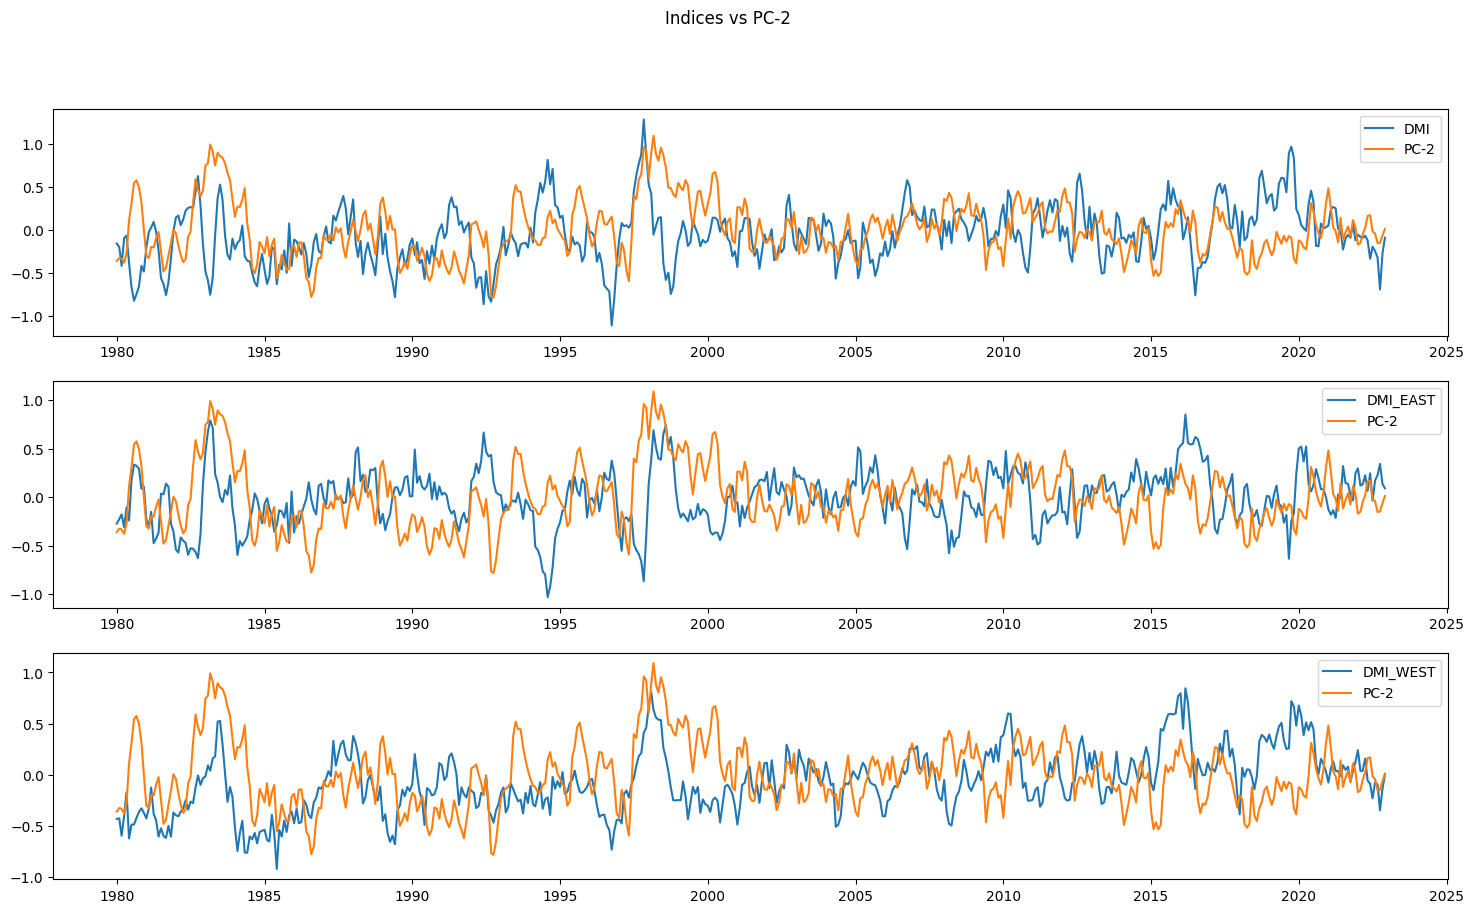

In [66]:
full_mei = []
for i in range(len(pcs[0][1][0])):
    for k in range(12):
        full_mei.append(pcs[k][1][1][i]*0.3)

melted = df_to_series(df_dmi, "DMI")
melted["DMI_EAST"] = df_to_series(df_dmi_east, "DMI_EAST")["DMI_EAST"]
melted["DMI_WEST"] = df_to_series(df_dmi_west, "DMI_WEST")["DMI_WEST"]
melted["PC-2"]= full_mei

print(melted.corr())

fig, axs = plt.subplots(3,1, figsize=(18,10))

axs[0].plot(melted.index, melted["DMI"], label="DMI")
axs[0].plot(melted.index, full_mei, label="PC-2")
axs[0].legend()

axs[1].plot(melted.index, melted["DMI_EAST"], label="DMI_EAST")
axs[1].plot(melted.index, full_mei, label="PC-2")
axs[1].legend()

axs[2].plot(melted.index, melted["DMI_WEST"], label="DMI_WEST")
axs[2].plot(melted.index, full_mei, label="PC-2")
axs[2].legend()


fig.suptitle("Indices vs PC-2")
plt.show()

## North Atlantic Oscillation (NAO)

The NAO is traditionally defined as the normalized pressure difference between a station on the Azores and one on Iceland

In [67]:
df_nao = pd.read_csv("nao.data",sep="   |  ", header=None, engine="python", names=col_labels)

           NAO      PC-2
NAO   1.000000 -0.036351
PC-2 -0.036351  1.000000


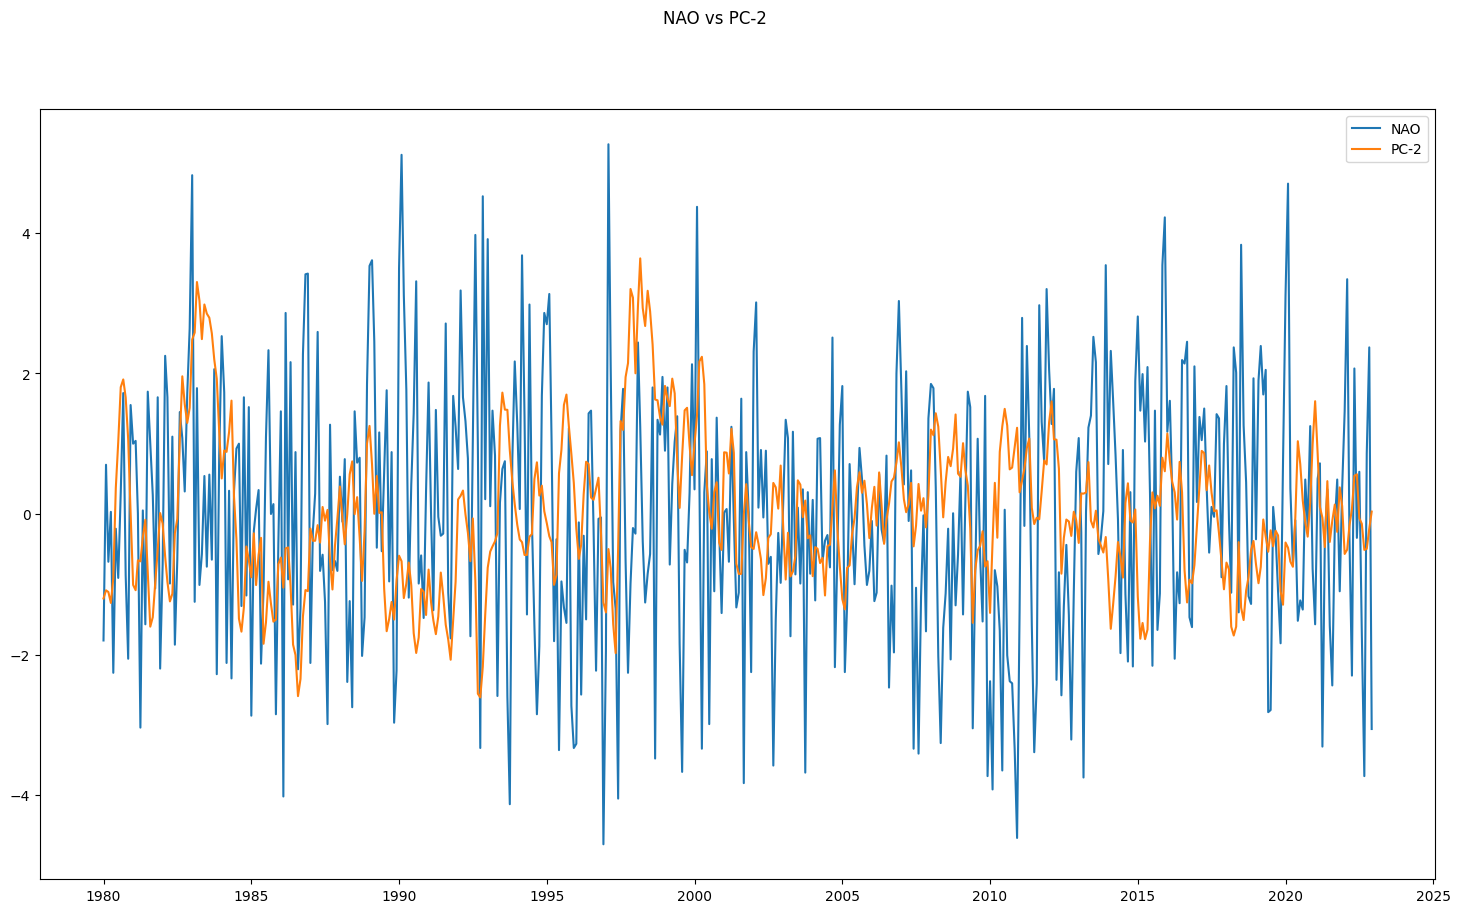

In [68]:
full_mei = []
for i in range(len(pcs[0][1][0])):
    for k in range(12):
        full_mei.append(pcs[k][1][1][i])

melted = df_to_series(df_nao, "NAO")
melted["PC-2"]= full_mei

print(melted.corr())

fig, axs = plt.subplots(1,1, figsize=(18,10))

axs.plot(melted.index, melted["NAO"], label="NAO")
axs.plot(melted.index, full_mei, label="PC-2")
axs.legend()
fig.suptitle("NAO vs PC-2")
plt.show()

## Arctic Oscillation (AO)

The loading pattern of the AO is defined by CPC as the leading mode of Empirical Orthogonal Function (EOF) analysis of monthly mean 1000mb height during 1979-2000 period

In [69]:
df_ao = pd.read_csv("ao.data",sep="  | ", header=None, engine="python", names=col_labels)

            AO      PC-2
AO    1.000000 -0.016614
PC-2 -0.016614  1.000000


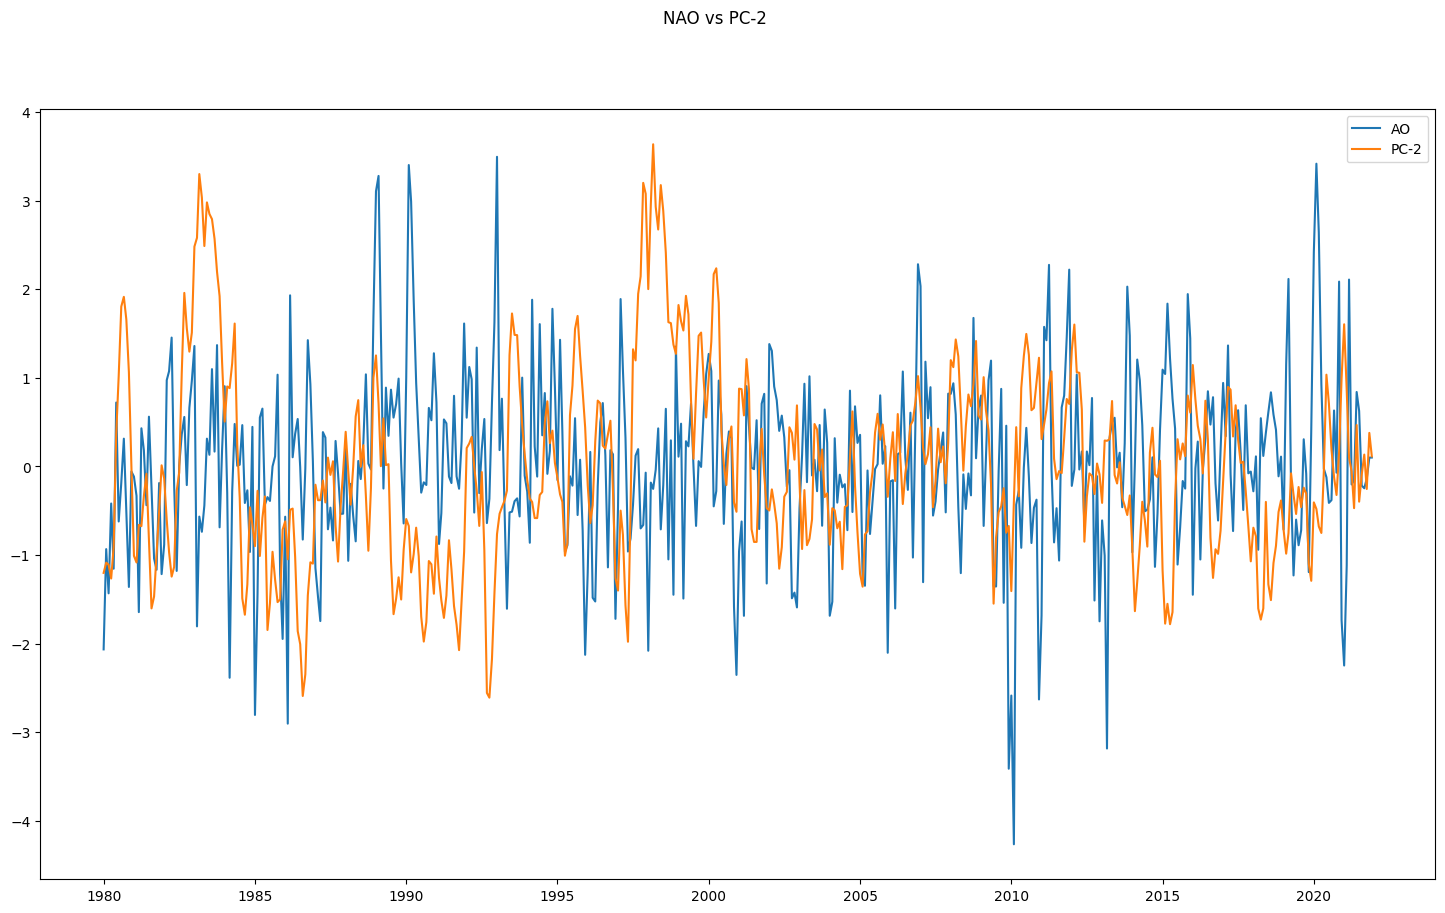

In [73]:
full_mei = []
for i in range(len(pcs[0][1][0])-1):
    for k in range(12):
        full_mei.append(pcs[k][1][1][i])

melted = df_to_series(df_ao, "AO")
melted["PC-2"]= full_mei

print(melted.corr())

fig, axs = plt.subplots(1,1, figsize=(18,10))

axs.plot(melted.index, melted["AO"], label="AO")
axs.plot(melted.index, full_mei, label="PC-2")
axs.legend()
fig.suptitle("NAO vs PC-2")
plt.show()

## Pacific Decadal Oscillation (PDO)

EOF analyses were calculated of the monthly SST were based on the temporal covariance matrix from the 1900-1993 period of record. using SST anomalies poleward of 20N in the Pacific basin.

In [71]:
df_pdo = pd.read_csv("pdo.data",sep="     |    |   |  ", header=None, engine="python", names=col_labels)

           PDO      PC-2
PDO   1.000000 -0.016259
PC-2 -0.016259  1.000000


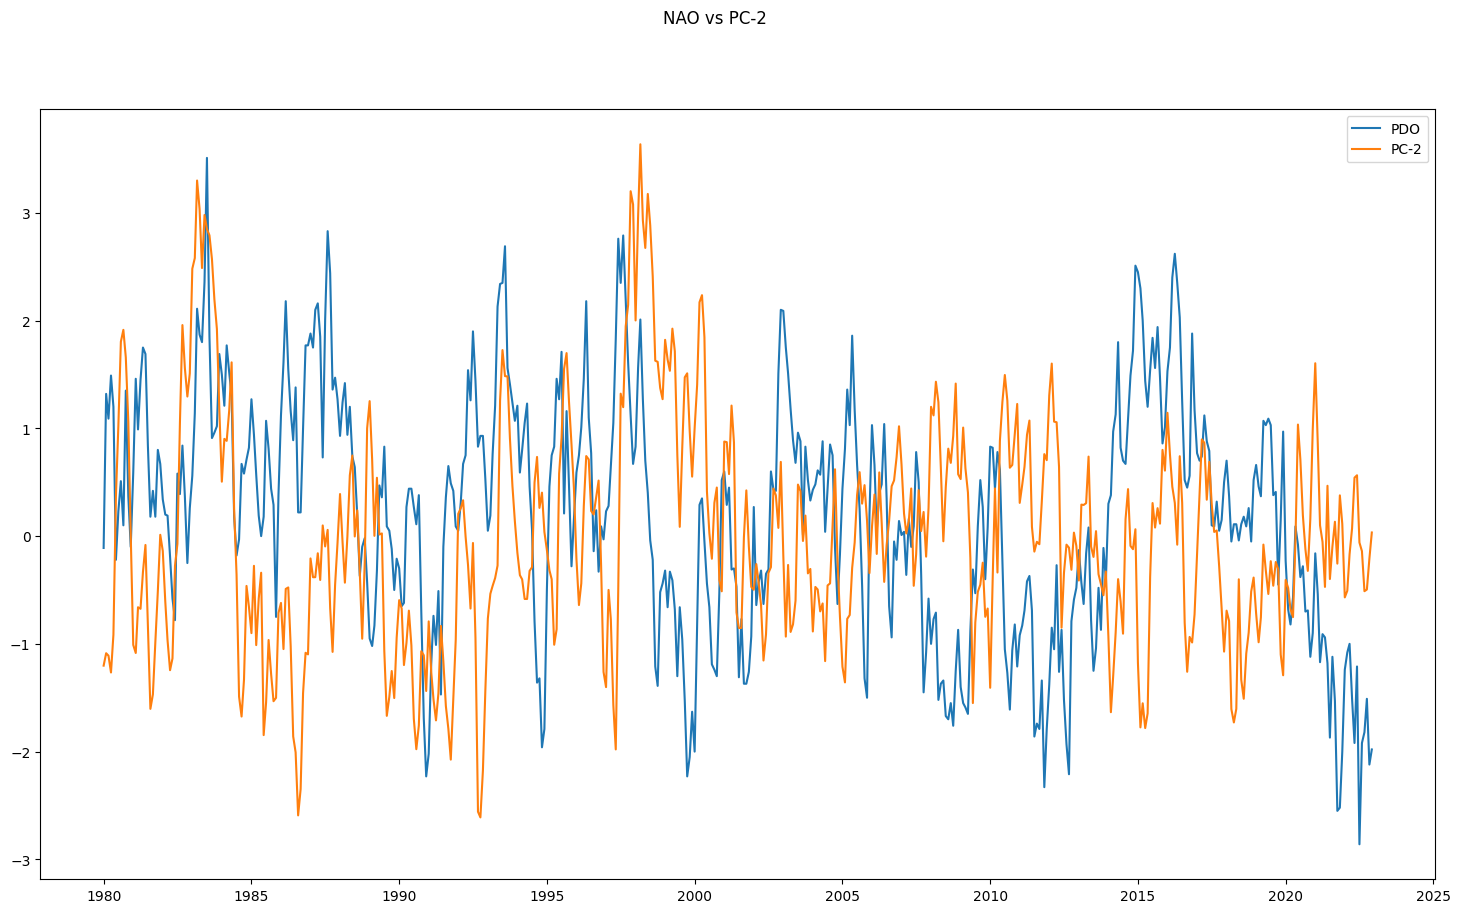

In [74]:
full_mei = []
for i in range(len(pcs[0][1][0])):
    for k in range(12):
        full_mei.append(pcs[k][1][1][i])

melted = df_to_series(df_pdo, "PDO")
melted["PC-2"]= full_mei

print(melted.corr())

fig, axs = plt.subplots(1,1, figsize=(18,10))

axs.plot(melted.index, melted["PDO"], label="PDO")
axs.plot(melted.index, full_mei, label="PC-2")
axs.legend()
fig.suptitle("NAO vs PC-2")
plt.show()

## Oceanic Niño Index (ONI)

3-month running mean from SST anomalies over the 3.4 Niño Region.

In [77]:
col_labels = ["Season", "Year", "Temp", "ONI"]

df_oni = pd.read_csv("oni.ascii.txt",sep="   |  | ", header=None, engine="python", names=col_labels)

In [78]:
df_oni

,Season,Year,Temp,ONI
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07
...,...,...,...,...
883,JAS,2023,28.28,1.32
884,ASO,2023,28.32,1.56
885,SON,2023,28.49,1.78
886,OND,2023,28.60,1.92


          ONI     PC-2
ONI   1.00000 -0.04614
PC-2 -0.04614  1.00000


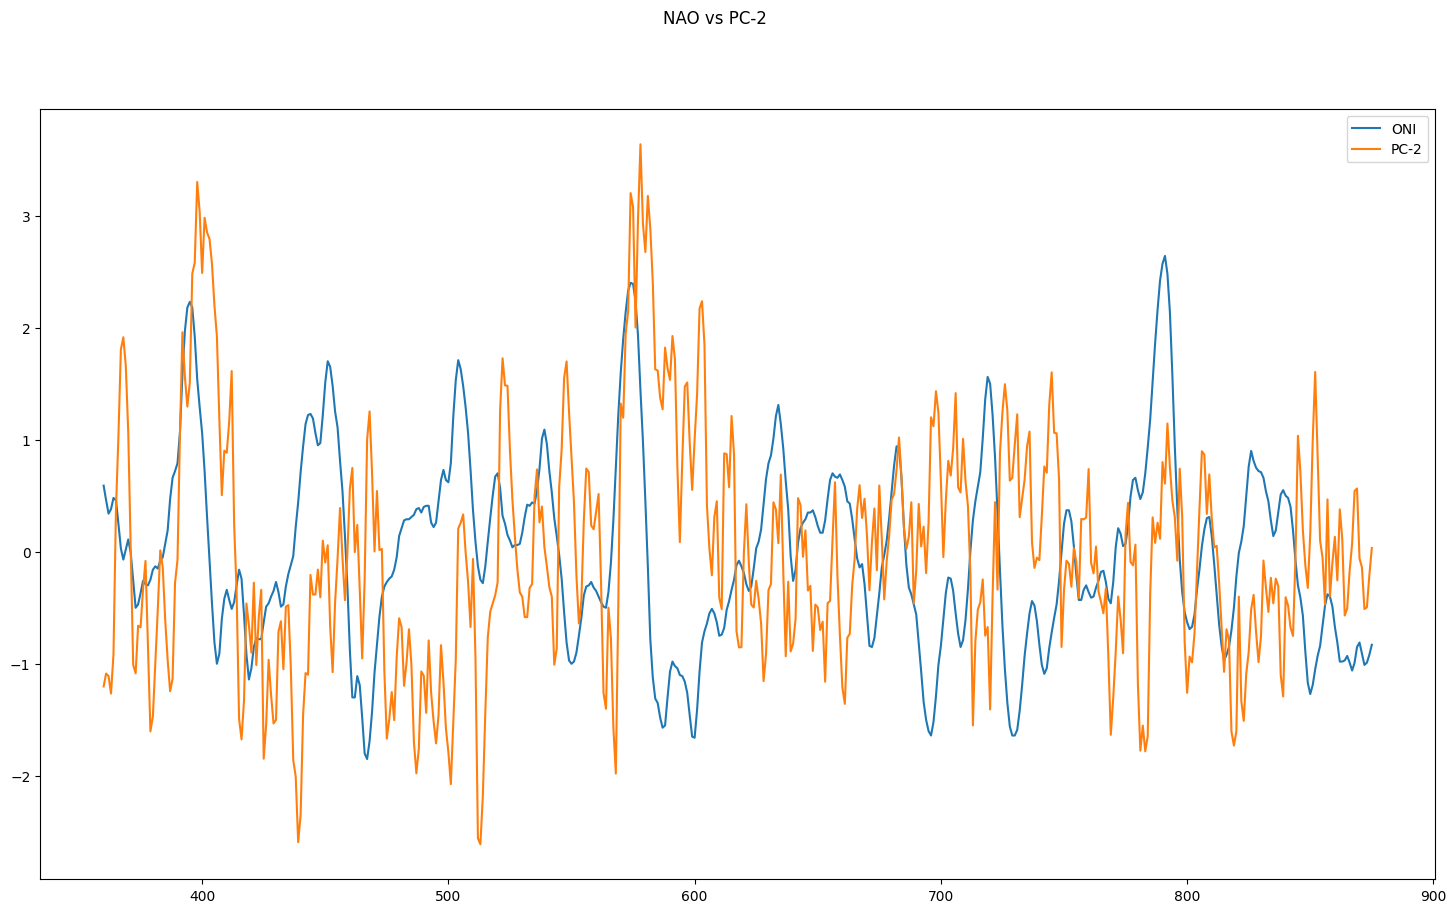

In [81]:

full_mei = []
for i in range(len(pcs[0][1][0])):
    for k in range(12):
        full_mei.append(pcs[k][1][1][i])


df_oni = df_oni[(df_oni["Year"]< 2023) & (df_oni["Year"] > 1979)]
melted = pd.DataFrame()
melted["ONI"] = df_oni["ONI"]
melted["PC-2"]= full_mei

print(melted.corr())

fig, axs = plt.subplots(1,1, figsize=(18,10))

axs.plot(melted.index, melted["ONI"], label="ONI")
axs.plot(melted.index, full_mei, label="PC-2")
axs.legend()
fig.suptitle("NAO vs PC-2")
plt.show()